In [1]:
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import os
import json
import ast
import pandas as pd
from urllib.parse import urlparse
import numpy as np
from urllib.parse import urlparse
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

from tqdm._tqdm_notebook import tqdm_notebook as tqdm
tqdm.pandas()


DATA_DIRECTORY = '../../data/reddit/Article_data_2019/'
candidates = [ "TRUMP", "SANDERS","DELANEY","WARREN","HARRIS","GILLIBRAND","O'ROURKE","KLOBUCHAR","BOOKER",
    "BUTTIGIEG","GABBARD","YANG","INSLEE","HICKENLOOPER","WILLIAMSON","CASTRO","BIDEN", "SWALWELL",
    "DE BLASIO", "BENNET"]
candidates = set([x.lower() for x in candidates])

[nltk_data] Downloading package punkt to /Users/kippy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Process Reddit Data

In [2]:
PICKLE_NAME = DATA_DIRECTORY + "reddit_2019_06_15_with_article_text.pkl"
df = pd.read_pickle(PICKLE_NAME)
dates_df = pd.read_pickle(DATA_DIRECTORY+'reddit_2019_dates.pkl')
df = df.merge(dates_df, how='left', on='id')

In [3]:
# Flatten the news dictionary
clean_df = pd.concat( [df.drop(['article_data'],axis=1), df['article_data'].progress_apply(pd.Series)]
                      ,axis = 1)
clean_df.drop(0, axis = 1, inplace=True)


def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

clean_df = df_column_uniquify(clean_df)

In [4]:
print(clean_df.shape)
print(clean_df[(~clean_df['title_1'].isnull()) & (~clean_df['text'].isnull())].shape)
print(clean_df[(~clean_df['title_1'].isnull()) & (~clean_df['text'].isnull())].drop_duplicates('url').shape)

(121986, 23)
(82018, 23)
(64581, 23)


In [5]:
# remove nulls, 
clean_df = clean_df[(~clean_df['title_1'].isnull()) & (~clean_df['text'].isnull())]
clean_df = clean_df.drop_duplicates('url')
clean_df["title_tokenized"] = clean_df.progress_apply(lambda x: [token.lower() for token in nltk.word_tokenize(x.title)]
                                                      , axis = 1)
clean_df["text_tokenized"] = clean_df.progress_apply(lambda x: [token.lower() for token in nltk.word_tokenize(x.text)]
                                                     , axis = 1)
clean_df["domain"] = clean_df.progress_apply(lambda x: urlparse(x.url).netloc, axis = 1)
clean_df['candidate_title'] = clean_df.progress_apply(lambda x: candidates.intersection(x.title_tokenized), axis=1)
clean_df['candidate_text'] = clean_df.progress_apply(lambda x: candidates.intersection(x.text_tokenized), axis=1)

Donations Data

In [6]:
# find the path to each fec file, store paths in a nested dict
fec_2020_paths = {}
base_path = os.path.join("../../","data","fec","2020")
for party_dir in os.listdir(base_path):
    if(party_dir[0]!="."):
        fec_2020_paths[party_dir] = {}
        for cand_dir in os.listdir(os.path.join(base_path,party_dir)):
            if(cand_dir[0]!="."):
                fec_2020_paths[party_dir][cand_dir] = {}
                for csv_path in os.listdir(os.path.join(base_path,party_dir,cand_dir)):
                    if(csv_path.find("schedule_a")>=0):
                        fec_2020_paths[party_dir][cand_dir]["donations"] = \
                            os.path.join(base_path,party_dir,cand_dir,csv_path)
                    elif(csv_path.find("schedule_b")>=0):
                        fec_2020_paths[party_dir][cand_dir]["spending"] = \
                            os.path.join(base_path,party_dir,cand_dir,csv_path)

In [7]:
fec_2020_paths

{'republican': {'trump': {'spending': '../../data/fec/2020/republican/trump/schedule_b-2019-05-30T16_03_37.csv',
   'donations': '../../data/fec/2020/republican/trump/schedule_a-2019-05-30T16_03_37.csv'}},
 'democrat': {'williamson': {'spending': '../../data/fec/2020/democrat/williamson/schedule_b-2019-05-30T20_41_44.csv',
   'donations': '../../data/fec/2020/democrat/williamson/schedule_a-2019-05-30T20_41_32.csv'},
  'harris': {'spending': '../../data/fec/2020/democrat/harris/schedule_b-2019-05-30T17_22_09.csv',
   'donations': '../../data/fec/2020/democrat/harris/schedule_a-2019-05-30T17_19_58.csv'},
  'buttigieg': {'donations': '../../data/fec/2020/democrat/buttigieg/schedule_a-2019-05-30T17_32_11.csv',
   'spending': '../../data/fec/2020/democrat/buttigieg/schedule_b-2019-05-30T17_32_14.csv'},
  'klobuchar': {'spending': '../../data/fec/2020/democrat/klobuchar/schedule_b-2019-05-30T17_28_05.csv',
   'donations': '../../data/fec/2020/democrat/klobuchar/schedule_a-2019-05-30T17_26_34

In [138]:
donate_df.columns

Index(['committee_id', 'committee_name', 'report_year', 'report_type',
       'image_number', 'line_number', 'transaction_id', 'file_number',
       'committee_name.1', 'entity_type', 'entity_type_desc',
       'unused_contbr_id', 'contributor_prefix', 'contributor_name',
       'recipient_committee_type', 'contributor_first_name',
       'contributor_middle_name', 'contributor_last_name',
       'contributor_suffix', 'contributor_street_1', 'contributor_street_2',
       'contributor_city', 'contributor_state', 'contributor_zip',
       'contributor_employer', 'contributor_occupation', 'contributor_id',
       'receipt_type', 'receipt_type_desc', 'receipt_type_full', 'memo_code',
       'memo_code_full', 'contribution_receipt_date',
       'contribution_receipt_amount', 'contributor_aggregate_ytd',
       'candidate_id', 'candidate_name', 'candidate_first_name',
       'candidate_last_name', 'candidate_middle_name', 'candidate_prefix',
       'candidate_suffix', 'candidate_office', 'c

In [10]:
def make_ts(candidate, paths, party):
    reddit_df = clean_df[clean_df.apply(lambda x: candidate in x.candidate_text, axis=1)]
    reddit_df['count'] = 1
    reddit_df = reddit_df[~reddit_df['created_utc'].isnull()]
    reddit_df['day'] = reddit_df['created_utc'].dt.round('D')
    
    if("donations" in paths[party][candidate].keys()):
            donate_df = pd.read_csv(paths[party][candidate]["donations"])
            donate_df['count_1'] = 1
            donate_df["contribution_receipt_date"] = pd.to_datetime(donate_df["contribution_receipt_date"])
            donate_df["day"] = donate_df["contribution_receipt_date"]
            ts = donate_df.groupby(by="day")["count_1"].sum().to_frame()
            
    reddit_ts = reddit_df.fillna(0)[['day', 'score', 'num_comments', 'count']].groupby(['day']).agg('sum')
    return ts.join(reddit_ts, how='outer').fillna(0)
    

In [11]:
candidate_dfs = dict()
for candidate in fec_2020_paths['democrat'].keys():
    candidate_dfs[candidate] = make_ts(candidate, fec_2020_paths, 'democrat')

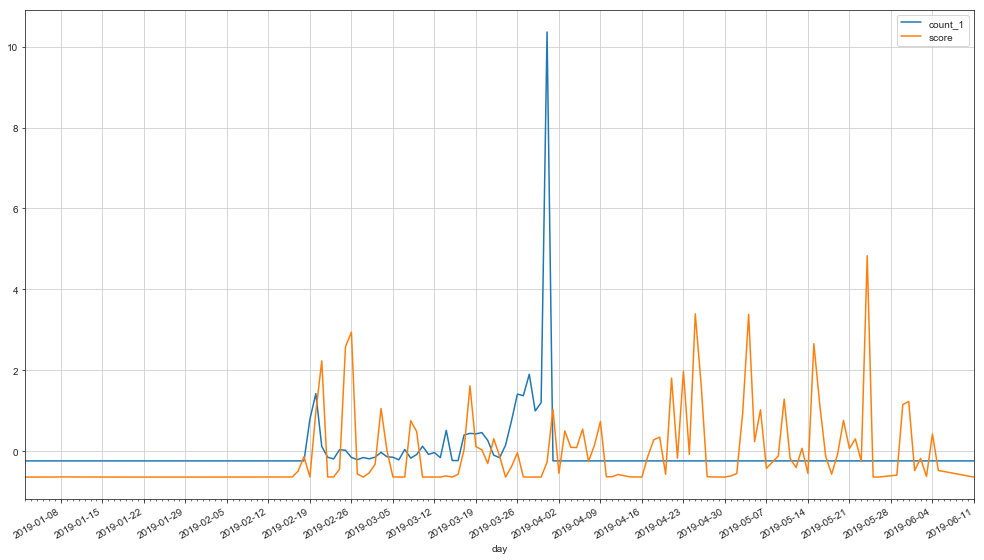

In [14]:
join_ts = candidate_dfs['sanders']
df_norm = (join_ts - join_ts.mean()) / join_ts.std()
sns.set_style('ticks')
ax = df_norm[['count_1', 'score']].plot(figsize=(17,10), x_compat=True)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid()
plt.show()